In [ ]:
pip install geemap

In [ ]:
import ee
ee.Authenticate()
ee.Initialize()



In [61]:
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt        
# Initialize the Earth Engine
# ee.Authenticate() # Uncomment if you need to authenticate
ee.Initialize()        

In [63]:
location = ee.FeatureCollection("projects/ee-mithileshpadhan/assets/debrigarh")


In [65]:
# Define the satellite imagery dataset (e.g., Landsat 8)
dataset = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')

# Filter the dataset by location and date range
filtered_dataset = dataset.filterBounds(location).filterDate('2013-01-01', '2024-12-31') 

In [67]:
# Define a function to calculate NDVI
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    return image.addBands(ndvi)

# Map the NDVI calculation function over the filtered dataset
ndvi_dataset = filtered_dataset.map(calculate_ndvi) 

In [ ]:
# Get time series data using reduceRegion
def extract_ndvi(image):
    date = image.date().format("YYYY-MM-dd")
    ndvi_value = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=location,
        scale=250  # MODIS resolution
    ).get("NDVI")
    return ee.Feature(None, {"date": date, "NDVI": ndvi_value})

# Convert to FeatureCollection
ndvi_time_series = ndvi_dataset.map(extract_ndvi)

# Convert to pandas DataFrame
ndvi_list = ndvi_time_series.aggregate_array("date").getInfo()
ndvi_values = ndvi_time_series.aggregate_array("NDVI").getInfo()

df = pd.DataFrame({"time": pd.to_datetime(ndvi_list), "NDVI": ndvi_values})

# Print first few rows
print(df.head())


In [ ]:

import matplotlib.pyplot as plt
import statsmodels.api as sm

# Convert time column to index
ndvi_series = df[['time', 'NDVI']].rename(columns={'time': 'Date'}).set_index('Date')

# Handle missing values: Fill NaN using interpolation
ndvi_series = ndvi_series.interpolate(method='linear')

# Resample data to monthly frequency using 'ME' instead of 'M'
ndvi_series = ndvi_series.resample('ME').mean()

# Drop any remaining NaN values
ndvi_series = ndvi_series.dropna()

# Plot NDVI over time
plt.figure(figsize=(12, 6))
plt.plot(ndvi_series.index, ndvi_series['NDVI'], marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('NDVI')
plt.title('NDVI Time Series')
plt.grid(True)
plt.show()

# Ensure at least 2 years of data for seasonal decomposition
if len(ndvi_series) >= 24:
    decomposition = sm.tsa.seasonal_decompose(ndvi_series['NDVI'], model='multiplicative', period=12)  # Set period=12 for monthly data
    fig = decomposition.plot()
    fig.set_size_inches(12, 8)
    plt.show()
else:
    print("Not enough data points for seasonal decomposition (need at least 2 years).")




In [ ]:
pip install pmdarima


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.ensemble import IsolationForest
import pmdarima as pm

# Ensure the time column is indexed
ndvi_series = df[['time', 'NDVI']].rename(columns={'time': 'Date'}).set_index('Date')

# Handle missing values
ndvi_series = ndvi_series.interpolate(method='linear').resample('ME').mean().dropna()

### 🔹 Auto ARIMA for Forecasting
auto_arima_model = pm.auto_arima(ndvi_series['NDVI'], seasonal=True, m=12, stepwise=True, trace=True)
print(auto_arima_model.summary())

# Forecast the next 12 months
forecast = auto_arima_model.predict(n_periods=12)
forecast_dates = [ndvi_series.index[-1] + pd.DateOffset(months=i) for i in range(1, 13)]

# Plot forecasted values
plt.figure(figsize=(10, 6))
plt.plot(ndvi_series.index, ndvi_series['NDVI'], label='Actual', marker='o')
plt.plot(forecast_dates, forecast, label='Forecast', linestyle='--', marker='o', color='red')
plt.legend()
plt.title('Vegetation Health Forecast of DEBRIGARH WLS, ODISHA(Auto ARIMA)')
plt.xlabel('Date')
plt.ylabel('NDVI')
plt.grid()
plt.show()

### 🔹 Anomaly Detection using Isolation Forest
X = ndvi_series['NDVI'].values.reshape(-1, 1)

# Train Isolation Forest
model = IsolationForest(contamination=0.1, random_state=42)
model.fit(X)

# Predict anomalies (-1 = outliers, 1 = normal)
anomalies = model.predict(X)

# Identify outlier indices
outlier_indices = np.where(anomalies == -1)[0]
outliers = ndvi_series.iloc[outlier_indices]

# Plot NDVI with anomalies highlighted
plt.figure(figsize=(10, 6))
plt.plot(ndvi_series.index, ndvi_series['NDVI'], label='NDVI')
plt.scatter(outliers.index, outliers['NDVI'], color='red', label='Anomalies', marker='x', s=100)
plt.title('Anomaly Detection using Isolation Forest')
plt.xlabel('Time')
plt.ylabel('NDVI')
plt.legend()
plt.grid()
plt.show()


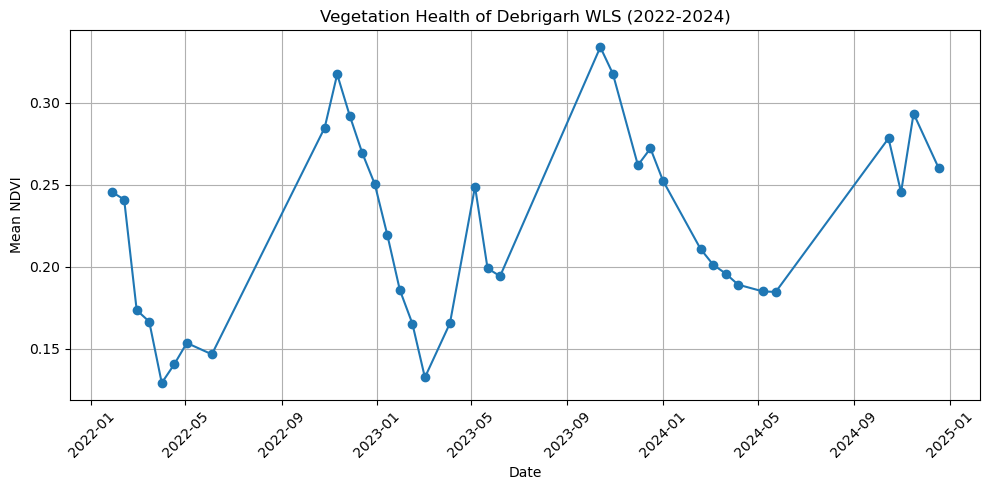

✅ NDVI time series saved as 'NDVI_Debrigarh_2024.csv'


In [79]:
import ee
import pandas as pd
import matplotlib.pyplot as plt

# Authenticate and initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Define your study area
location = ee.FeatureCollection("projects/ee-mithileshpadhan/assets/debrigarh")

# Load Landsat 8 collection for 2024
dataset = ee.ImageCollection('LANDSAT/LC08/C02/T1_L2') \
    .filterBounds(location) \
    .filterDate('2022-01-01', '2024-12-31') \
    .filter(ee.Filter.lt('CLOUD_COVER', 20))

# Calculate NDVI and add date
def calculate_ndvi(image):
    ndvi = image.normalizedDifference(['SR_B5', 'SR_B4']).rename('NDVI')
    return image.addBands(ndvi).set('date', image.date().format('YYYY-MM-dd'))

ndvi_dataset = dataset.map(calculate_ndvi)

# Reduce to mean NDVI per image
def reduce_mean_ndvi(image):
    mean = image.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=location.geometry(),
        scale=30,
        maxPixels=1e9
    )
    return ee.Feature(None, {
        'date': image.get('date'),
        'NDVI': mean.get('NDVI')
    })

ndvi_fc = ndvi_dataset.map(reduce_mean_ndvi)

# Convert to list of features
features = ndvi_fc.getInfo()['features']

# Extract to lists
dates = [f['properties']['date'] for f in features]
ndvi_values = [f['properties']['NDVI'] for f in features]

# Create pandas DataFrame
df = pd.DataFrame({'date': dates, 'NDVI': ndvi_values})
df['date'] = pd.to_datetime(df['date'])
df = df.dropna().sort_values('date')

# Plot the NDVI time series
plt.figure(figsize=(10, 5))
plt.plot(df['date'], df['NDVI'], marker='o', linestyle='-')
plt.title('Vegetation Health of Debrigarh WLS (2022-2024)')
plt.xlabel('Date')
plt.ylabel('Mean NDVI')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Export to CSV
df.to_csv('NDVI_Debrigarh_2024.csv', index=False)
print("✅ NDVI time series saved as 'NDVI_Debrigarh_2024.csv'")
